In [1]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
%matplotlib inline


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def display_image(img, label=None, save_image=False):
    image_array = img.numpy()
    plt.axis("off")

    if label:
        plt.text(75, 8, label, fontstyle='italic', fontweight='bold',
                 bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

    plt.imshow(np.transpose(image_array, (1, 2, 0)))
    plt.show()

def plot_loss_curve(iterations, losses):
    plt.figure()
    plt.plot(iterations, losses, color='blue', linewidth=2)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Loss over Iterations")
    plt.grid(True)
    plt.show()

batch_size = 64
epochs = 100


In [5]:

# Define data paths and training parameters
train_path = "/content/drive/My Drive/data/faces/training/"
test_path = "/content/drive/My Drive/data/faces/testing/"


# Load the training dataset from the specified path
dataset_train = datasets.ImageFolder(root=train_path)


In [6]:
from PIL import Image, ImageOps
import random
import torch
import numpy as np
from torch.utils.data import Dataset

class PairedImageDataset(Dataset):

    def __init__(self, dataset, transform=None, invert_images=False):
        self.dataset = dataset
        self.transform = transform
        self.invert_images = invert_images

    def __getitem__(self, idx):
        img_a_info = random.choice(self.dataset.imgs)
        is_same_class = random.choice([True, False])

        if is_same_class:
            while True:
                img_b_info = random.choice(self.dataset.imgs)
                if img_a_info[1] == img_b_info[1]:
                    break
        else:
            while True:
                img_b_info = random.choice(self.dataset.imgs)
                if img_a_info[1] != img_b_info[1]:
                    break


        img_a = Image.open(img_a_info[0]).convert("L")
        img_b = Image.open(img_b_info[0]).convert("L")

        if self.invert_images:
            img_a = ImageOps.invert(img_a)
            img_b = ImageOps.invert(img_b)

        if self.transform:
            img_a = self.transform(img_a)
            img_b = self.transform(img_b)

        label = torch.tensor([float(img_a_info[1] != img_b_info[1])], dtype=torch.float32)
        return img_a, img_b, label

    def __len__(self):
        return len(self.dataset.imgs)


In [7]:
training_data = datasets.ImageFolder(root=train_path)


In [8]:
paired_data = PairedImageDataset(
    dataset=training_data,
    transform=transforms.Compose([
        transforms.Resize((100, 100)),
        transforms.ToTensor()
    ]),
    invert_images=False
)


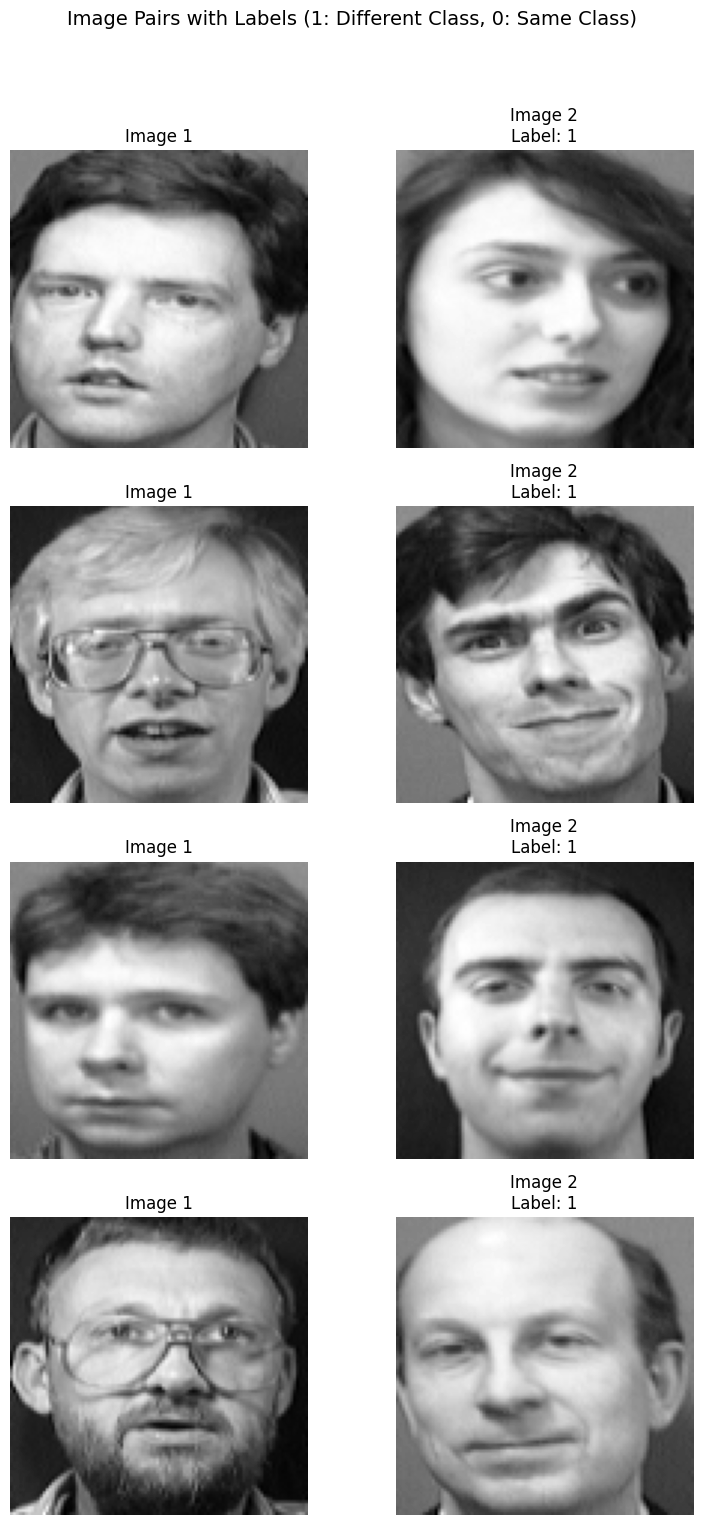

In [12]:
import matplotlib.pyplot as plt

display_loader = DataLoader(
    paired_data,
    shuffle=True,
    num_workers=4,
    batch_size=4
)

batch_iter = iter(display_loader)
sample_batch = next(batch_iter)

img1_batch, img2_batch, labels = sample_batch

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(8, 16))
fig.suptitle("Image Pairs with Labels (1: Different Class, 0: Same Class)", fontsize=14)


for i in range(4):
    axes[i, 0].imshow(img1_batch[i].permute(1, 2, 0), cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 0].set_title("Image 1")

    axes[i, 1].imshow(img2_batch[i].permute(1, 2, 0), cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f"Image 2\nLabel: {int(labels[i].item())}")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [13]:
class EnhancedSiameseNetwork(nn.Module):
    def __init__(self):
        super(EnhancedSiameseNetwork, self).__init__()

        # Convolutional Layers
        self.conv_layers = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 16, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),

            nn.ReflectionPad2d(1),
            nn.Conv2d(16, 32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),

            nn.ReflectionPad2d(1),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),

            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128)
        )

        # Fully Connected Layers
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 100 * 100, 512),
            nn.ReLU(inplace=True),

            nn.Linear(512, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256, 128),
            nn.ReLU(inplace=True),

            nn.Linear(128, 5)
        )

    def forward_once(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


In [14]:
import torch
import torch.nn.functional as F

class DistanceLoss(torch.nn.Module):

#contrastive loss using L1 distance(Manhattan)

    def __init__(self, margin=2.0):
        super(DistanceLoss, self).__init__()
        self.margin = margin

    def calculate_l1_distance(self, output_a, output_b):
        l1_distance = torch.abs(output_a - output_b)
        return torch.sum(l1_distance, dim=1, keepdim=True)

    def compute_loss_components(self, l1_distance, target):
        loss_pos = (1 - target) * torch.pow(l1_distance, 2)
        loss_neg = target * torch.pow(torch.clamp(self.margin - l1_distance, min=0.0), 2)
        return loss_pos, loss_neg

    def forward(self, output_a, output_b, target):
        l1_distance = self.calculate_l1_distance(output_a, output_b)
        loss_pos, loss_neg = self.compute_loss_components(l1_distance, target)
        total_loss = torch.mean(loss_pos + loss_neg)
        return total_loss


In [16]:
from torch.utils.data import DataLoader


training_dataloader = DataLoader(
    paired_data,
    shuffle=True,
    num_workers=4,
    batch_size=32
)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [18]:
training_iterations = []
loss_records = []
current_iteration = 0

Epoch: 1/150, Batch: 0, Current Contrastive Loss: 0.0950
Epoch: 1/150, Batch: 10, Current Contrastive Loss: 0.2118
Epoch: 2/150, Batch: 0, Current Contrastive Loss: 0.1500
Epoch: 2/150, Batch: 10, Current Contrastive Loss: 0.0961
Epoch: 3/150, Batch: 0, Current Contrastive Loss: 0.1329
Epoch: 3/150, Batch: 10, Current Contrastive Loss: 0.0794
Epoch: 4/150, Batch: 0, Current Contrastive Loss: 0.0394
Epoch: 4/150, Batch: 10, Current Contrastive Loss: 0.1264
Epoch: 5/150, Batch: 0, Current Contrastive Loss: 0.1055
Epoch: 5/150, Batch: 10, Current Contrastive Loss: 0.1331
Epoch: 6/150, Batch: 0, Current Contrastive Loss: 0.0924
Epoch: 6/150, Batch: 10, Current Contrastive Loss: 0.0734
Epoch: 7/150, Batch: 0, Current Contrastive Loss: 0.1355
Epoch: 7/150, Batch: 10, Current Contrastive Loss: 0.0384
Epoch: 8/150, Batch: 0, Current Contrastive Loss: 0.0921
Epoch: 8/150, Batch: 10, Current Contrastive Loss: 0.0776
Epoch: 9/150, Batch: 0, Current Contrastive Loss: 0.0652
Epoch: 9/150, Batch: 10

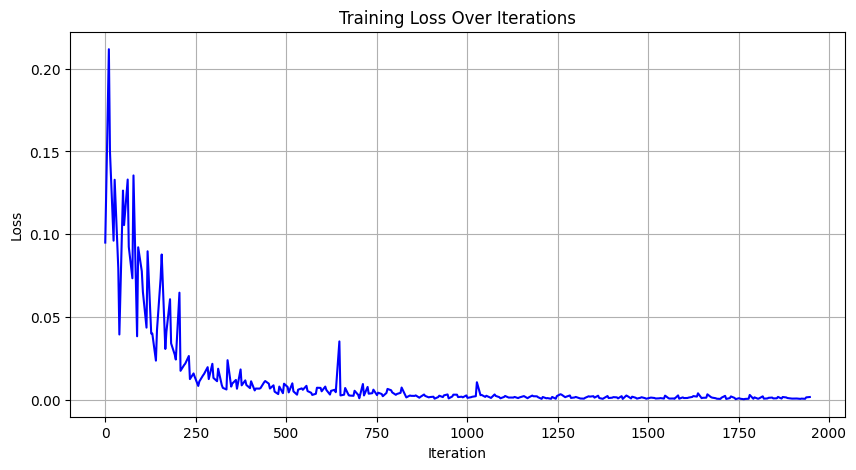

In [22]:
import matplotlib.pyplot as plt

num_epochs = 150
loss_records = []
iteration_tracker = []

for epoch in range(num_epochs):
    for batch_idx, (img0, img1, labels) in enumerate(training_dataloader):
        img0, img1, labels = img0.cuda(), img1.cuda(), labels.cuda()
        optimizer.zero_grad()
        output1, output2 = model(img0, img1)
        loss_value = loss_function(output1, output2, labels)
        loss_value.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            print(f"Epoch: {epoch + 1}/{num_epochs}, Batch: {batch_idx}, Current Contrastive Loss: {loss_value.item():.4f}")
            iteration_tracker.append(epoch * len(training_dataloader) + batch_idx)
            loss_records.append(loss_value.item())

plt.figure(figsize=(10, 5))
plt.plot(iteration_tracker, loss_records, color='blue')
plt.title('Training Loss Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


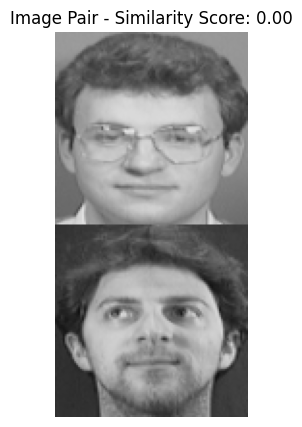

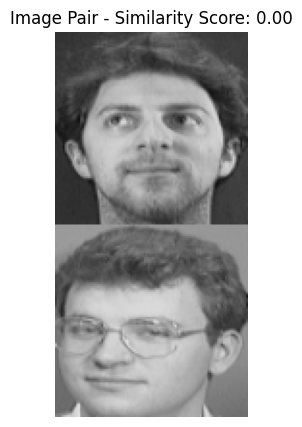

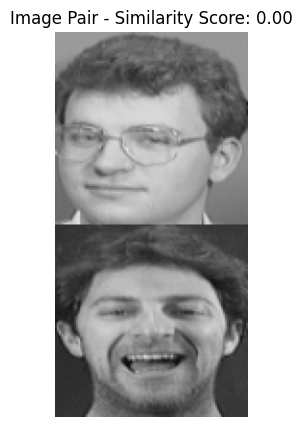

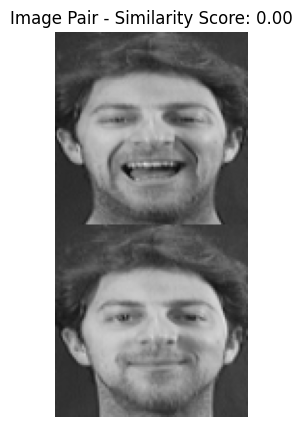

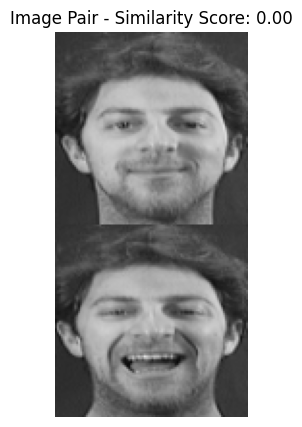

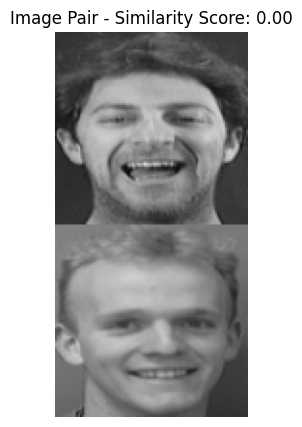

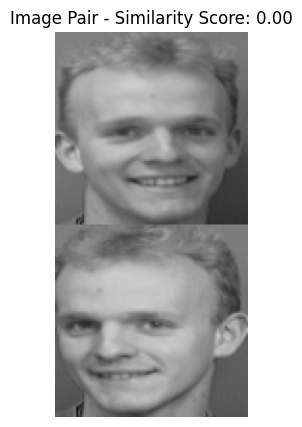

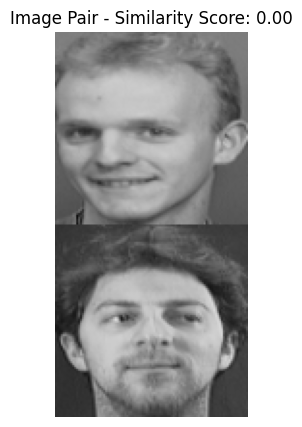

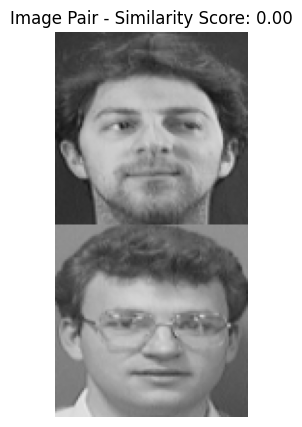

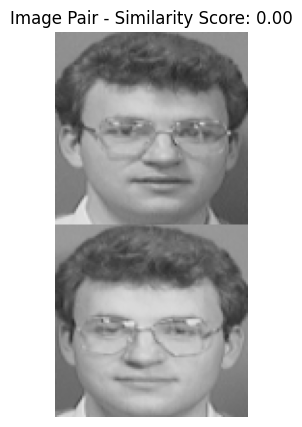

In [27]:
model = EnhancedSiameseNetwork().cuda()
loss_function = DistanceLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

folder_dataset_test = datasets.ImageFolder(root=test_path)

siamese_test_dataset = PairedImageDataset(
    dataset=folder_dataset_test,
    transform=transforms.Compose([
        transforms.Resize((100, 100)),
        transforms.ToTensor()
    ]),
    invert_images=False
)

test_dataloader = DataLoader(siamese_test_dataset, num_workers=6, batch_size=1, shuffle=True)
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

for i in range(10):
    _, x1, label2 = next(dataiter)
    concatenated = torch.cat((x0, x1), dim=2)
    output1, output2 = model(Variable(x0).cuda(), Variable(x1).cuda())
    l1_distance = torch.sum(torch.abs(output1 - output2)).item()
    similarity_score = 1 - (l1_distance / (l1_distance + 1e-8))
    plt.figure(figsize=(10, 5))
    plt.axis('off')
    plt.title('Image Pair - Similarity Score: {:.2f}'.format(similarity_score))
    plt.imshow(np.transpose(torchvision.utils.make_grid(concatenated, nrow=1).cpu(), (1, 2, 0)))
    plt.show()
    x0 = x1.clone()

